In [24]:
from skimage import io, transform
import toolz as tz
from toolz.curried import map as cmap
from toolz.curried import partition, accumulate
from glob import glob
from skimage.color import rgb2gray
from skimage import transform
from toolz import curried
import matplotlib.pyplot as plt
from operator import add

In [25]:
from skimage.feature import ORB, match_descriptors, plot_matches

In [26]:
def detect_points(image0, image1):
    orb = ORB(n_keypoints=4000, fast_threshold=0.05)

    orb.detect_and_extract(image0)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    orb.detect_and_extract(image1)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
    return keypoints1, keypoints2, matches12

In [27]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

# Select keypoints from the source (image to be registered)
# and target (reference image)

def select_keypoints(keypoints1, keypoints2, matches12):
    src = keypoints2[matches12[:, 1]][:, ::-1]
    dst = keypoints1[matches12[:, 0]][:, ::-1]

    model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=15, max_trials=500)
    return model_robust

In [28]:
def unpacker(func):
    def _wrapper(args):
        return func(*args)
    return _wrapper
def attr_pluck(name):
    def _wrapper(obj):
        return getattr(obj, name)
    return _wrapper
def pack(obj):
    return obj,
import numpy as np


In [48]:
def get_filenames_gen(image_pattern):
    return tz.pipe(glob(image_pattern),
                   sorted)

In [69]:
rescale = lambda img: transform.rescale(img, 0.25)
image_pattern = '/home/bartosz/Documents/Tree/*.jpg'
pipe = tz.pipe(
        get_filenames_gen(image_pattern),
        cmap(io.imread),
        cmap(rgb2gray),
        cmap(rescale),
        partition(2),
        cmap(unpacker(detect_points)),
        cmap(unpacker(select_keypoints)),
        cmap(attr_pluck('params'))
       )

In [70]:
from skimage.transform import warp

transform_images = tz.map(tz.curry(warp, cval=-1),
                          
                          tz.pipe(
                           get_filenames_gen(image_pattern),
                           curried.drop(1),
                           cmap(io.imread),
                           cmap(rescale)),

                          tz.pipe(pipe,
                            cmap(transform.ProjectiveTransform),
                            accumulate(add),
                            cmap(attr_pluck('inverse'))))
                                 


In [52]:
t = next(transform_images)

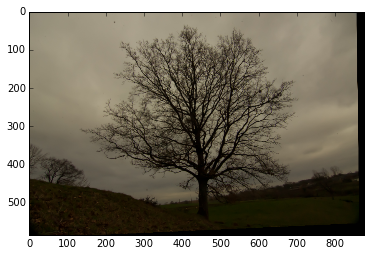

In [53]:
%matplotlib inline
plt.imshow(t)

In [58]:
import os
def mk_filename(p, result_dir='./registered'):
    directory, fname = os.path.split(p)
    new_path = os.path.join(result_dir, fname)
    return new_path


In [63]:
io.imsave?

In [71]:
save_images = tz.map(io.imsave, 
                   tz.map(mk_filename,
                          tz.pipe(get_filenames_gen(image_pattern),
                                  curried.drop(1))
                          ),
                   transform_images)

In [73]:
list(save_images)

/home/bartosz/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


KeyboardInterrupt: 